In [1]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
fake = pd.read_csv('Fake.csv', parse_dates=['date'])
true = pd.read_csv('True.csv', parse_dates=['date'])

fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25
...,...,...,...,...
23445,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16
23446,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16
23447,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15
23448,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14


fake date column is not parsing correctly, possibly means that there are non date-values in the column

Some of the dates are marked as URLs. Given the size of the fake dataset overall, we will be dropping these columns

In [3]:
true

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22


In [4]:
#create a target column for each dataset. 0 = Fake News, 1 = Real News
fake['news type'] = 0
true['news type'] = 1

In [5]:
#concat dataframes into one dataset
news = pd.concat([fake, true], ignore_index = True)
news

,title,text,subject,date,news type
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0
...,...,...,...,...,...
44862,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,1
44863,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,1
44864,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,1
44865,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,1


## EDA

In [6]:
#check no.of entries
news.shape

(44867, 5)

In [7]:
#check null columns
news.isnull().sum()

title        0
text         0
subject      0
date         0
news type    0
dtype: int64

In [8]:
#how many unique subjects based on whether they are real or fake news
news[news['news type'] == 0]['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [9]:
news[news['news type'] == 1]['subject'].unique()

array(['politicsNews', 'worldnews'], dtype=object)

Seems like the subject categories are not consistent between the real and fake news sources. likely means that we either need to restandardize or not use that feature in particular

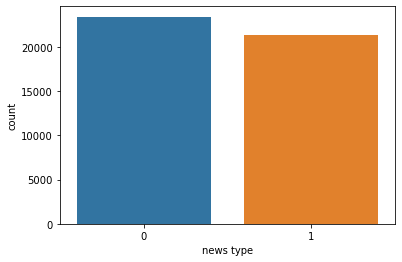

In [10]:
sns.countplot(x = 'news type', data = news)

In [11]:
news['news type'].value_counts(normalize = True)

0    0.522656
1    0.477344
Name: news type, dtype: float64

In [12]:
news['news type'].value_counts()

0    23450
1    21417
Name: news type, dtype: int64

In [13]:
news

,title,text,subject,date,news type
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0
...,...,...,...,...,...
44862,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,1
44863,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,1
44864,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,1
44865,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,1


Dataset is pretty evenly split between Real and Fake news. We have slightly more data points for Fake news vs real.

In [6]:
#create columns for twitter handles

# news['title_twt'] = news['title'].apply(lambda x:set(re.findall('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',x))) 
# news['text_twt'] = news['text'].apply(lambda x:set(re.findall('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',x)))

news['title_twt'] = "" 
news['text_twt'] = ""

In [6]:
temp = 0
z = 0


for i in news['text'] :
    temp = re.findall('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',i)
    if len(temp) > 0:
        news['text_twt'].iloc[z] = set(temp)
        z += 1
    else :
        news['text_twt'].iloc[z] = ""
        z += 1

C:\Users\Faizal Rahman\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
temp = 0
z = 0


for i in news['title'] :
    temp = re.findall('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',i)
    if len(temp) > 0:
        news['title_twt'].iloc[z] = set(temp)
        z += 1
    else :
        news['title_twt'].iloc[z] = ""
        z += 1

In [8]:
twt = news[news['text_twt'].map(len) > 0]
twt

,Unnamed: 0,title,text,subject,date,news type,title_twt,text_twt,kmeans_cluster
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0,,"{calvinstowell, AlanSandoval13, thbthttt, Kore...",[0]
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0,,"{SheriffClarke, feltrrr2, chrismohney, KeithLe...",[1]
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0,,"{tw1trsux, timrpeterson, pbump}",[0]
6,6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,2017-12-23,0,,"{realDonaldTrump, FoxNews}",[0]
8,8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,2017-12-22,0,,"{realDonaldTrump, JohnBrennan}",[0]
...,...,...,...,...,...,...,...,...,...
43165,43165,Factbox: Trump on Twitter (September 18) - CIA...,The following statements were posted to the ve...,worldnews,2017-09-19,1,,"{CIA, USAirForce, EmmanuelMacron, realDonaldTr...",[1]
43224,43224,Factbox: Trump on Twitter (Sept 18) - U.S. Air...,The following statements were posted to the ve...,worldnews,2017-09-18,1,,"{POTUS, realDonaldTrump, CIA, USAirForce}",[1]
43248,43248,China Communist Party complains about 'fabrica...,BEIJING (Reuters) - The youth wing of China s ...,worldnews,2017-09-18,1,,"{ComYouthLeague, ccylchina}",[1]
43280,43280,Factbox: What Trump has said about the United ...,WASHINGTON (Reuters) - U.S. President Donald T...,worldnews,2017-09-17,1,,{Israel},[1]


In [12]:
news = news.drop(columns=['Unnamed: 0'])

In [14]:
news['text_count'] = news['text'].apply(lambda x: len(x.split()))

In [15]:
news

,title,text,subject,date,news type,title_twt,text_twt,kmeans_cluster,text_count
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0,,"{calvinstowell, AlanSandoval13, thbthttt, Kore...",[0],495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0,,,[0],305
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0,,"{SheriffClarke, feltrrr2, chrismohney, KeithLe...",[1],580
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0,,"{tw1trsux, timrpeterson, pbump}",[0],444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0,,,[1],420
...,...,...,...,...,...,...,...,...,...
44862,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,1,,,[1],466
44863,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,1,,,[1],125
44864,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,1,,,[1],320
44865,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,1,,,[1],205


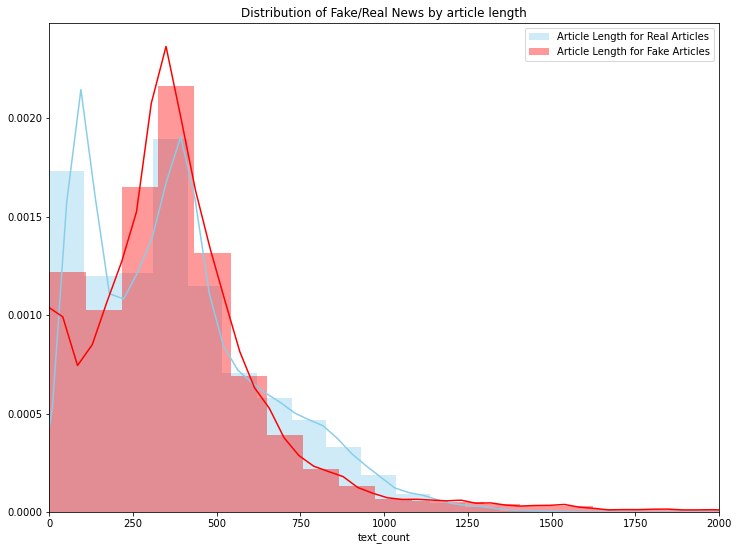

In [74]:
plt.figure(figsize=(12,9))
ax = sns.distplot(news[news['news type'] == 1]['text_count'], color="skyblue", label="Article Length for Real Articles")
ax = sns.distplot(news[news['news type'] == 0]['text_count'],color="red", label="Article Length for Fake Articles")
ax.set_xlim([0,2000]) 
plt.title('Distribution of Fake/Real News by article length')
plt.legend()

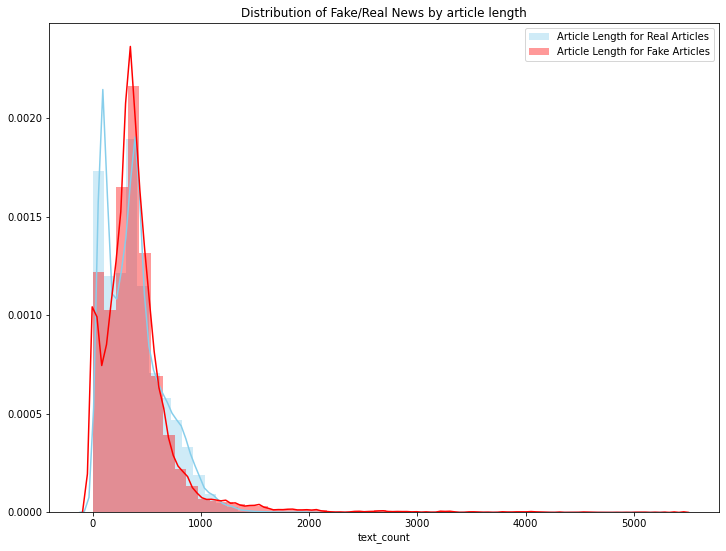

In [50]:
plt.figure(figsize=(12,9))
sns.distplot(news[news['news type'] == 1]['text_count'], color="skyblue", label="Article Length for Real Articles")
sns.distplot(news[news['news type'] == 0]['text_count'],color="red", label="Article Length for Fake Articles")
plt.title('Distribution of Fake/Real News by article length')
plt.legend()

In [17]:
news.to_csv('news.csv')

Text(0.5, 1.0, 'Fake (0) and Real (1) News Articles featuring Twitter Handles')

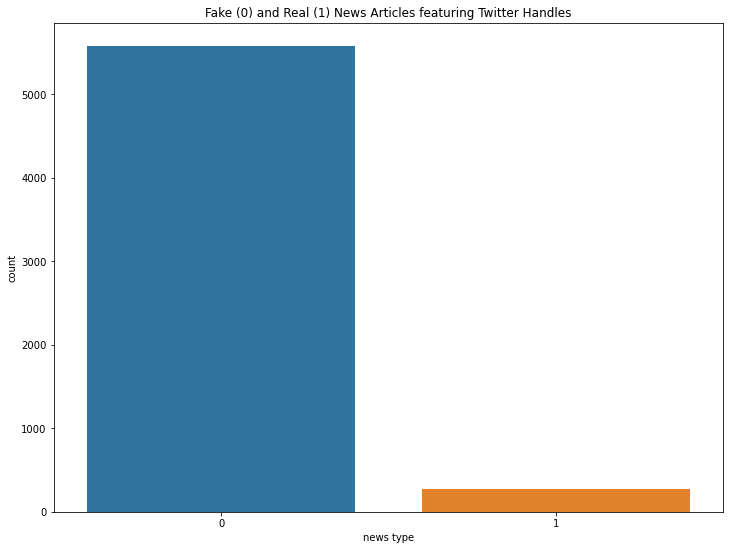

In [10]:
plt.figure(figsize=(12,9))
sns.countplot(x="news type", data=twt)
plt.title('Fake (0) and Real (1) News Articles featuring Twitter Handles')


- News articles containing twitter handles are significantly more likely to be fake news rather than real news. 
- This presents a problem when creating the model, as the model will develop biases towards news articles with twitter handles

In [10]:
twt['handles_count'] = twt['text_twt'].map(len)

<ipython-input-10-0fca321d2055>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twt['handles_count'] = twt['text_twt'].map(len)


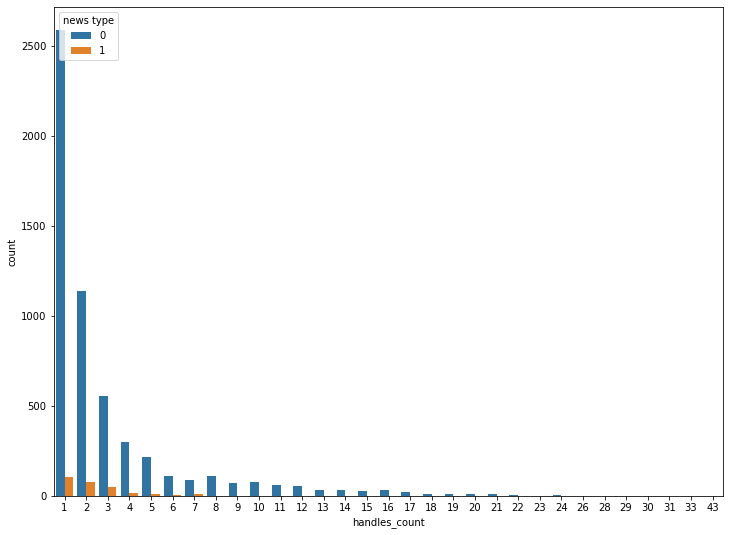

In [14]:
plt.figure(figsize=(12,9))
sns.countplot(x="handles_count", hue='news type', data=twt)

### Identifying specific word frequency in fake/real news predictions

In [35]:
news

,title,text,subject,date,news type,title_twt,text_twt,kmeans_cluster,text_count
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0,,"{calvinstowell, AlanSandoval13, thbthttt, Kore...",[0],495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0,,,[0],305
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0,,"{SheriffClarke, feltrrr2, chrismohney, KeithLe...",[1],580
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0,,"{tw1trsux, timrpeterson, pbump}",[0],444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0,,,[1],420
...,...,...,...,...,...,...,...,...,...
44862,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,1,,,[1],466
44863,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,1,,,[1],125
44864,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,1,,,[1],320
44865,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,1,,,[1],205


In [45]:
#collapse news data set into a collection of text based on fake/real news types
words = news.groupby('news type')['text'].apply(' '.join).reset_index()
words

,news type,text
0,0,Donald Trump just couldn t wish all Americans ...
1,1,WASHINGTON (Reuters) - The head of a conservat...


In [54]:
type(words['text'][0])

str

In [86]:
#use countvectorizer

txt = [words['text'][0]]
vec = CountVectorizer(stop_words ='english').fit(txt)
bag_of_words = vec.transform(txt)
sum_words = bag_of_words.sum(axis=0) 
words_freq_fake = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_fake =sorted(words_freq_fake, key = lambda x: x[1], reverse=True)


In [82]:

txt = [words['text'][1]]
vec = CountVectorizer(stop_words ='english').fit(txt)
bag_of_words = vec.transform(txt)
sum_words = bag_of_words.sum(axis=0) 
words_freq_real = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
words_freq_real =sorted(words_freq_real, key = lambda x: x[1], reverse=True)


In [95]:
top_fake = pd.DataFrame(words_freq_fake[:16], columns = ['keyword','frequency'])
top_real = pd.DataFrame(words_freq_real[:16], columns = ['keyword','frequency'])

In [91]:
top_fake

,keyword,frequency
0,trump,79024
1,said,33622
2,president,27559
3,people,26428
4,just,20404
5,clinton,18931
6,obama,18742
7,like,17910
8,donald,17611
9,news,14355


In [92]:
top_real

,keyword,frequency
0,said,99062
1,trump,54700
2,reuters,28976
3,president,28177
4,state,21025
5,government,18846
6,new,16917
7,states,16652
8,house,16640
9,republican,16243


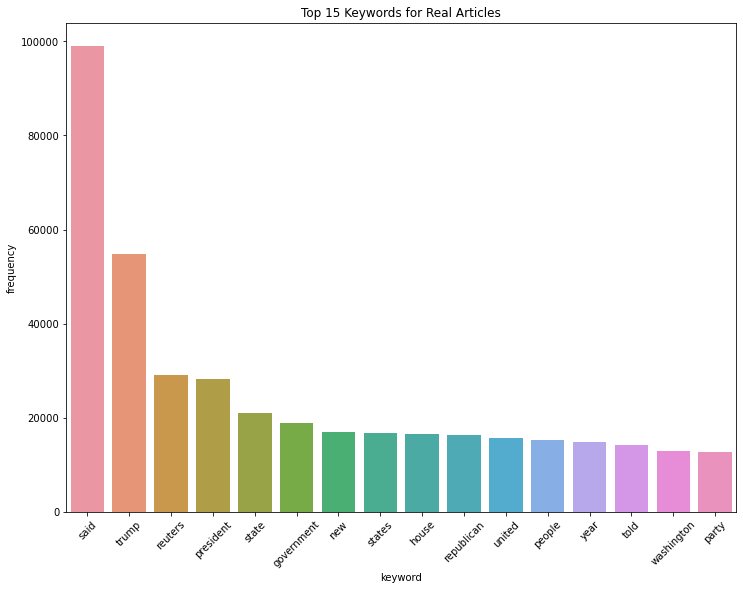

In [98]:
plt.figure(figsize = (12,9))
real_bar = sns.barplot(x="keyword", y="frequency", data=top_real)
plt.title("Top 15 Keywords for Real Articles")
for item in real_bar.get_xticklabels():
    item.set_rotation(45)

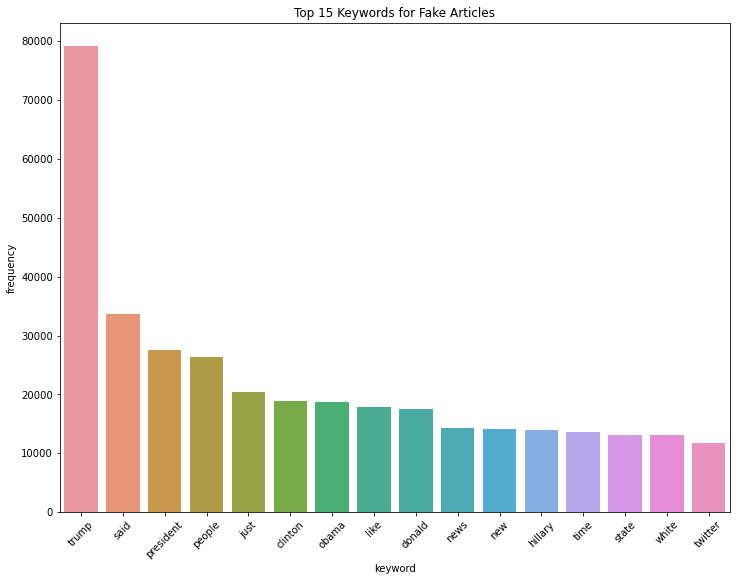

In [99]:
plt.figure(figsize = (12,9))
real_bar = sns.barplot(x="keyword", y="frequency", data=top_fake)
plt.title("Top 15 Keywords for Fake Articles")
for item in real_bar.get_xticklabels():
    item.set_rotation(45)

## KMeans EDA

In [24]:
news

,title,text,subject,date,news type,title_twt,text_twt,kmeans_cluster,text_count
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0,,"{calvinstowell, AlanSandoval13, thbthttt, Kore...",[0],495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0,,,[0],305
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0,,"{SheriffClarke, feltrrr2, chrismohney, KeithLe...",[1],580
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0,,"{tw1trsux, timrpeterson, pbump}",[0],444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0,,,[1],420
...,...,...,...,...,...,...,...,...,...
44862,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,1,,,[1],466
44863,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,1,,,[1],125
44864,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,1,,,[1],320
44865,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,1,,,[1],205


In [25]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(news['text'])

In [17]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(X)

KMeans(max_iter=100, n_clusters=2)

In [18]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [19]:
for i in range(true_k):
 print("Cluster " + str(i) ),
 for ind in order_centroids[i, :10]:
     print(terms[ind])

Cluster 0
trump
said
clinton
president
donald
republican
campaign
house
white
hillary
Cluster 1
said
state
reuters
president
government
people
police
obama
trump
united


In [24]:
news.to_csv('news.csv')

Kmeans cluster were not meaningfully useful in determining if specific words are key to identifying fake/real news 

In [37]:
X1 = vectorizer.transform(["Republicans have had seven years to come up with a viable replacement for Obamacare but they failed miserably. After taking a victory lap for gifting the wealthy with a tax break on Wednesday, Donald Trump looked at the cameras and said,  We have essentially repealed Obamacare and we will come up with something that will be much better. Obamacare has been repealed in this bill,  he added. Well, like most things Trump says, that s just not true. But, if the former reality show star could have done that in order to eradicate former President Obama s signature legislation, he would have and without offering an alternative.Senate Majority Leader Mitch McConnell told NPR that  This has not been a very bipartisan year. I hope in the new year, we re going to pivot here and become more cooperative. An Obamacare repeal in 2018 is DOA. Well, we obviously were unable to completely repeal and replace with a 52-48 Senate,  the Kentucky Republican said.  We ll have to take a look at what that looks like with a 51-49 Senate. But I think we ll probably move on to other issues. NPR reports:McConnell hopes to focus instead on stabilizing the insurance marketplaces to keep premiums from skyrocketing in the early months of 2018, a promise he made to moderate Republican Sen. Susan Collins of Maine to get her support for the tax bill.On top of that McConnell broke with House Speaker Paul Ryan, R-Wis., on the approach to paring back spending on programs like Medicaid and food stamps. McConnell told NPR he is  not interested  in using Senate budget rules to allow Republicans to cut entitlements without consultation with Democrats. I think entitlement changes, to be sustained, almost always have to be bipartisan,  McConnell said.  The House may have a different agenda. If our Democratic friends in the Senate want to join us to tackle any kind of entitlement reform. I d be happy to take a look at it. This is coming from Mitch McConnell. He knows Donald Trump is destroying the GOP. It doesn t matter, Sen. McConnell. We still recall him saying that his  number one priority is making sure president Obama s a one-term president. Well, we re hoping that Trump doesn t last a full term. Funny how that works.Photo by Chip Somodevilla/Getty Images"])
predicted = model.predict(X1)
print(predicted)

[1]


## Modelling

- For the purposes of this analysis, we will use the text field, and make some minor data cleansing in order to predict whether it is fake or real news
- Will also be interesting to see the accuracy rating based on the title of the article alone, to see whether using that can allow for prediction of articles just as good

In [101]:
news['twt_count'] = news['text_twt'].apply(lambda x: len(x))
news

,title,text,subject,date,news type,title_twt,text_twt,kmeans_cluster,text_count,twt_count
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0,,"{calvinstowell, AlanSandoval13, thbthttt, Kore...",[0],495,12
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0,,,[0],305,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0,,"{SheriffClarke, feltrrr2, chrismohney, KeithLe...",[1],580,13
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0,,"{tw1trsux, timrpeterson, pbump}",[0],444,3
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0,,,[1],420,0
...,...,...,...,...,...,...,...,...,...,...
44862,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,1,,,[1],466,0
44863,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,1,,,[1],125,0
44864,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,1,,,[1],320,0
44865,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,1,,,[1],205,0


In [103]:
#create a deep copy of dataframe excluding twitter handles
news= news[news['twt_count'] == 0].copy()
news

,title,text,subject,date,news type,title_twt,text_twt,kmeans_cluster,text_count,twt_count
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0,,,[0],305,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0,,,[1],420,0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,2017-12-25,0,,,[1],312,0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,2017-12-23,0,,,[0],376,0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,2017-12-21,0,,,[0],286,0
...,...,...,...,...,...,...,...,...,...,...
44862,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,1,,,[1],466,0
44863,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,1,,,[1],125,0
44864,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,1,,,[1],320,0
44865,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,1,,,[1],205,0


In [92]:
#train test split

X = news['text']
y = news['news type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)


In [93]:
#write function to clean text data, set to lower case, remove extra spaces

def clean(data) :
    cleaned = []
    
    for i in data :
        i = i.lower()
        i = re.sub('https?://\S+|www\.\S+', '', i)
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        cleaned.append(i)
    return cleaned

X_train = clean(X_train)
X_test = clean(X_test)


In [94]:
#tokenize text
nwords = 10000
tokenizer = Tokenizer(num_words = nwords)
tokenizer.fit_on_texts(X_train)

In [95]:
#convert text to vectors, as the model only accepts numerical data

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [96]:
#add padding to achieve the same length for each article
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)


In [97]:
#build the RNN

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(nwords, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
________________________________________________

In [99]:
%%time

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True)

Epoch 1/10
937/937 [==============================] - 172s 183ms/step - loss: 0.2713 - accuracy: 0.8722 - val_loss: 0.1267 - val_accuracy: 0.9616
Epoch 2/10
937/937 [==============================] - 173s 184ms/step - loss: 0.0882 - accuracy: 0.9764 - val_loss: 0.0738 - val_accuracy: 0.9740
Epoch 3/10
937/937 [==============================] - 162s 173ms/step - loss: 0.0432 - accuracy: 0.9894 - val_loss: 0.0558 - val_accuracy: 0.9846
Epoch 4/10
937/937 [==============================] - 138s 147ms/step - loss: 0.0276 - accuracy: 0.9940 - val_loss: 0.0439 - val_accuracy: 0.9872
Epoch 5/10
937/937 [==============================] - 157s 168ms/step - loss: 0.0157 - accuracy: 0.9965 - val_loss: 0.0474 - val_accuracy: 0.9875
Epoch 6/10
937/937 [==============================] - 171s 183ms/step - loss: 0.0108 - accuracy: 0.9974 - val_loss: 0.0442 - val_accuracy: 0.9888
Epoch 7/10
937/937 [==============================] - 165s 176ms/step - loss: 0.0090 - accuracy: 0.9983 - val_loss: 0.0685 -

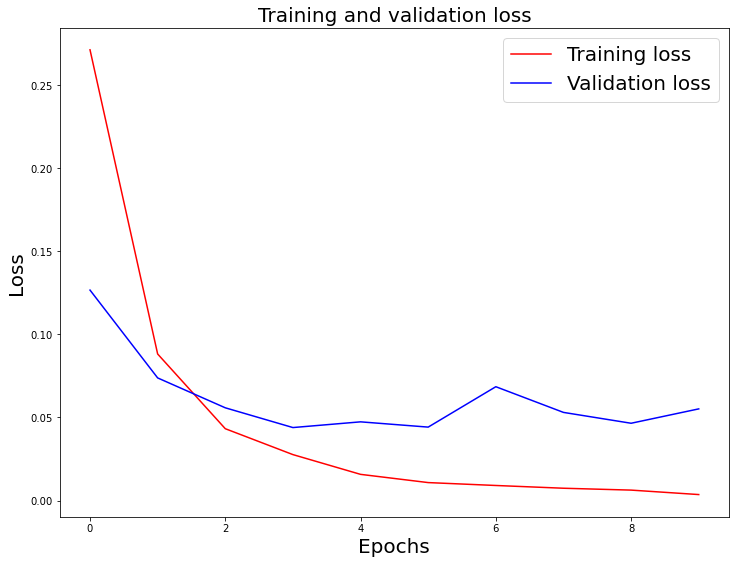

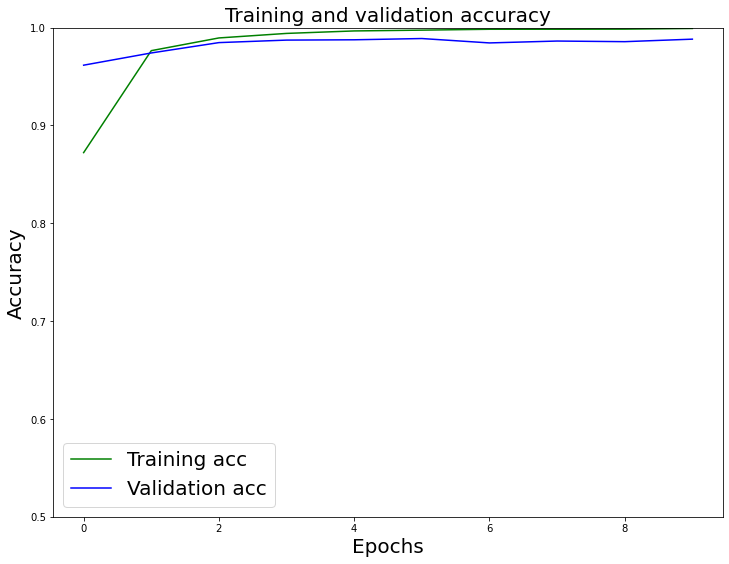

In [100]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [101]:
model.evaluate(X_test, y_test)

244/244 [==============================] - 10s 42ms/step - loss: 0.0569 - accuracy: 0.9896


[0.05692270025610924, 0.9896193742752075]

In [102]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [103]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9896193771626297
Precision on testing set: 0.9904317386231039
Recall on testing set: 0.9906629318394025


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

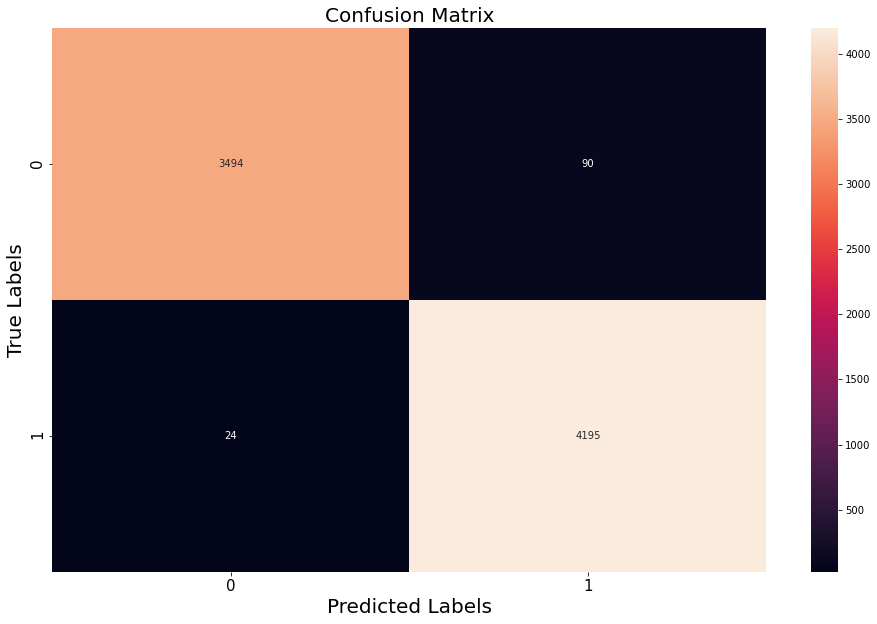

In [116]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)


In [44]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [45]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:nwords-1]

## Naive Bayes (TFIDF)

In [197]:
#define target and features

X = news['text']
y = news['news type']



In [198]:
#convert X input to tfidf vectors

tfidf = TfidfVectorizer(stop_words='english', max_features=15000)
X = tfidf.fit_transform(X).toarray()

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)


In [200]:
%%time

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

Wall time: 1.43 s


In [203]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.918236575676022
Precision: 0.9132109675957398
Recall: 0.94049008168028


## Logistic Regression (TFIDF)

In [204]:
#define target and features

X = news['text']
y = news['news type']



In [205]:
#convert X input to tfidf vectors

tfidf = TfidfVectorizer(stop_words='english', max_features=15000)
X = tfidf.fit_transform(X).toarray()

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)


In [208]:
%%time

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

Wall time: 10 s


In [209]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9844931436626938
Precision: 0.9814986123959297
Recall: 0.9904317386231039


## Naive Bayes (BOW)

In [2]:
news = pd.read_csv('news.csv')

In [5]:
#define target and features

X = news['text']
y = news['news type']



In [6]:
#utilize countvectorizer

cvz = CountVectorizer(stop_words='english', max_features=15000)
X = cvz.fit_transform(X).toarray()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)


In [8]:
%%time

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

Wall time: 47 s


In [9]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9310521594258618
Precision: 0.9280328992460589
Recall: 0.9479579929988331


## Logistic Regression (BOW)

In [10]:
#define target and features

X = news['text']
y = news['news type']



In [11]:
#convert X input to tfidf vectors

cvz = CountVectorizer(stop_words='english', max_features=15000)
X = cvz.fit_transform(X).toarray()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)


In [13]:
%%time

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

C:\Users\Faizal Rahman\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wall time: 46.7 s


In [15]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9939766756375753
Precision: 0.9944003733084461
Recall: 0.99463243873979


## Using 'Reuters' as a keyword

In [18]:
news['reuters_pred'] = ""

In [44]:
%%time

z = 0

for i in news['text'] :
    if len(re.findall(r'reuters', i.lower())) > 0:
        news['reuters_pred'].iloc[z] = 1
        z += 1
    else :
        news['reuters_pred'].iloc[z] = 0
        z += 1

C:\Users\Faizal Rahman\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Wall time: 8.07 s


In [45]:
news['reuters_pred'].value_counts()

1    21364
0    17649
Name: reuters_pred, dtype: int64

In [46]:
TP = news[(news['news type'] == 1) & (news['reuters_pred'] == 1)].shape[0]
TN = news[(news['news type'] == 0) & (news['reuters_pred'] == 0)].shape[0]
FP = news[(news['news type'] == 0) & (news['reuters_pred'] == 1)].shape[0]
FN = news[(news['news type'] == 1) & (news['reuters_pred'] == 0)].shape[0]

acc = (TP+TN)/(TP+TN+FP+FN)
prec = TP/(TP+FP)
recall = TN/(TN+FN)

print("Accuracy: " +str(acc) )
print("Precision:" +str(prec))
print("Recall:" +str(recall))

Accuracy: 0.9923615205188014
Precision:0.9878299943830743
Recall:0.9978469035072809


## Usage of CNN

In [79]:
#train test split

X = news['text']
y = news['news type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)


In [80]:
#write function to clean text data, set to lower case, remove extra spaces

def clean(data) :
    cleaned = []
    
    for i in data :
        i = i.lower()
        i = re.sub('https?://\S+|www\.\S+', '', i)
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        cleaned.append(i)
    return cleaned

X_train = clean(X_train)
X_test = clean(X_test)


In [81]:
#tokenize text
nwords = 10000
tokenizer = Tokenizer(num_words = nwords)
tokenizer.fit_on_texts(X_train)

In [82]:
#convert text to vectors, as the model only accepts numerical data

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [83]:
#add padding to achieve the same length for each article
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)


In [84]:
input_dim = X_train.shape[1]

model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_dim=input_dim),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                2570      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,581
Trainable params: 2,581
Non-trainable params: 0
_________________________________________________________________


In [86]:
%%time

model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True)

Epoch 1/10
937/937 [==============================] - 1s 839us/step - loss: 0.7435 - accuracy: 0.5307 - val_loss: 0.7554 - val_accuracy: 0.5069
Epoch 2/10
937/937 [==============================] - 1s 680us/step - loss: 0.7315 - accuracy: 0.5290 - val_loss: 0.7332 - val_accuracy: 0.5069
Epoch 3/10
937/937 [==============================] - 1s 824us/step - loss: 0.7211 - accuracy: 0.5237 - val_loss: 0.7341 - val_accuracy: 0.5127
Epoch 4/10
937/937 [==============================] - 1s 861us/step - loss: 0.7202 - accuracy: 0.5272 - val_loss: 0.7307 - val_accuracy: 0.5136
Epoch 5/10
937/937 [==============================] - 1s 866us/step - loss: 0.7175 - accuracy: 0.5274 - val_loss: 0.7305 - val_accuracy: 0.5159
Epoch 6/10
937/937 [==============================] - 1s 872us/step - loss: 0.7124 - accuracy: 0.5229 - val_loss: 0.7171 - val_accuracy: 0.5095
Epoch 7/10
937/937 [==============================] - 1s 775us/step - loss: 0.7061 - accuracy: 0.5148 - val_loss: 0.7127 - val_accuracy:

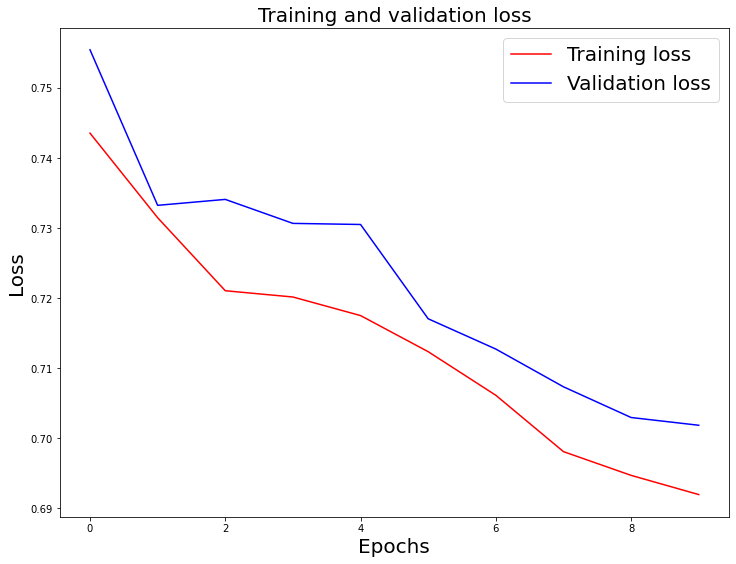

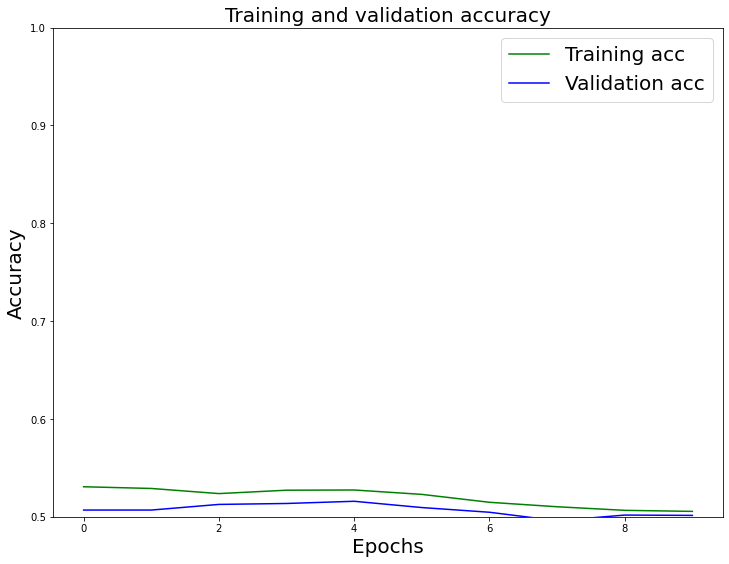

In [87]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [88]:
model2.evaluate(X_test, y_test)

244/244 [==============================] - 0s 521us/step - loss: 0.6937 - accuracy: 0.4990


[0.69367915391922, 0.49903884530067444]

In [90]:
pred = model2.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [91]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.499038831218762
Precision on testing set: 0.21773628938156359
Recall on testing set: 0.6261744966442953
